In [1]:
####################
# import packages
####################

import sys
import os
print(sys.version)
os.path.dirname(sys.executable)

# import packages
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import util
import pandas as pd
from collections import Counter
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.utils import generic_utils
from keras.callbacks import ModelCheckpoint
import numpy as np
from numpy import concatenate
import scipy 
import math
from math import sqrt
import h5py
import time
#Vector Autoregression
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from sklearn.metrics import mean_absolute_error

3.6.4 (v3.6.4:d48eceb, Dec 19 2017, 06:54:40) [MSC v.1900 64 bit (AMD64)]


C:\Users\Katy Lyon\AppData\Local\Programs\Python\Python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#math.log(1)
#adh = math.log(1)*0 + math.log(0.54)*1 + math.log(0.6)*1  + \
#      math.log(0.91)*1 + math.log(0.43)*1 + math.log(0.98)*10
#print(adh)

In [2]:
syn_view_df = pd.read_csv("C:/Users/Katy Lyon/Documents/William/PhD/Data/VIEW/Synthetic Data/Synthetic_VIEW.csv", sep=",")
print(syn_view_df.shape)
print(syn_view_df.columns)
print(syn_view_df.iloc[0:5, :])
idxs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
syn_view_v = syn_view_df.iloc[:, idxs].values
print(syn_view_v[0:5, :])
print(syn_view_v.shape)

(2451278, 21)
Index(['Unnamed: 0', 'ag_age', 'ag_sex', 'ag_eth', 'pt_nzdep', 'imp_hxdiab',
       'pt_tc_hdl_ratio', 'pt_bps', 'pt_bpd', 'pt_smoke', 'imp_hxcvd',
       'imp_hdl', 'imp_ldl', 'imp_tchol', 'marker', 'region', 'PH_BL_LLD_ANY',
       'PH_BL_AHT_ANY', 'pt_familyhistory', 'ab_gen', 'eth_gen'],
      dtype='object')
   Unnamed: 0     ag_age ag_sex ag_eth  pt_nzdep  imp_hxdiab  pt_tc_hdl_ratio  \
0        4014  30.176226   Male    Chi         4           0         4.059027   
1        4015  30.374727   Male    Chi         4           0         2.852025   
2        4016  30.516754   Male    Chi         4           0         4.217859   
3        4017  30.399679   Male    Chi         4           0         4.185350   
4        4018  30.467144   Male    Chi         4           0         4.949277   

       pt_bps     pt_bpd  pt_smoke   ...      imp_hdl   imp_ldl  imp_tchol  \
0  119.218682  84.992284         0   ...     1.325313  2.868344   5.051568   
1  109.537986  69.886582    

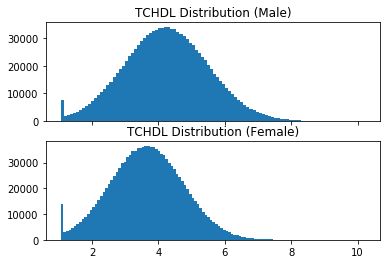

In [3]:
syn_view_mv = syn_view_v[syn_view_v[:, 1]=='Male']
syn_view_fv = syn_view_v[syn_view_v[:, 1]=='Female']
#f, (ax1, ax2) = pyplot.subplots(1, 2, sharey=True)
f, axarr = pyplot.subplots(2, sharex=True)
axarr[0].hist(list(syn_view_mv[:, 5]), 100)
axarr[0].set_title('TCHDL Distribution (Male)')
axarr[1].hist(list(syn_view_fv[:, 5]), 100)
axarr[1].set_title('TCHDL Distribution (Female)')


#ax1.hist(list(syn_view_mv[:, 5]), 100)
#ax1.set_title('TCHDL Distribution (Male)')
#ax2.hist(list(syn_view_fv[:, 5]), 100)
#ax2.set_title('TCHDL Distribution (Female)')

#n, bins, patches = pyplot.hist(list(syn_view_mv[:, 5]), 100)
#pyplot.xlabel('TCHDL')
#pyplot.ylabel('Count')
#pyplot.title('TCHDL Distribution (Male)')
pyplot.show()

In [23]:
#['ag_age', 'ag_sex', 'ag_eth', 'pt_nzdep', 'imp_hxdiab',
#'pt_tc_hdl_ratio', 'pt_bps', 'pt_bpd', 'pt_smoke', 'imp_hxcvd',
#'imp_hdl', 'imp_ldl', 'imp_tchol', 'marker', 'region', 
#'PH_BL_LLD_ANY', 'PH_BL_AHT_ANY', 'pt_familyhistory']


# NZ Framingham 
excluded_list = []
excluded_count = 0

time_series_list = []
for i in range(299000, 299001):#len(syn_view_v) #280
    ind = syn_view_v[i, :]
    
    fram_age = ind[0]
    fram_sex = 0 if ind[1] == "Male" else 1
    fram_eth = ind[2]
    fram_nzdep = ind[3]
    fram_hxdiab = ind[4]
    fram_tchdl = ind[5]
    fram_sbp = ind[6]
    fram_dbp = ind[7]
    fram_smoke = ind[8]
    fram_hxcvd = ind[9]
    fram_hdl = ind[10]
    fram_ldl = ind[11]    
    fram_tchol = ind[12]
    fram_region = ind[14]
    fram_lld = ind[15]
    fram_aht = ind[16]
    fram_familyhistory = ind[17]
    
    #####################################
    # Calculate NZ Framingham Risk Score
    #####################################
    risk_horizon = 5
    new_nu = (18.8144 - 1.2146*fram_sex - 1.8443*math.log(fram_age) +
             0.3668*math.log(fram_age)*fram_sex - 1.4032*math.log(fram_sbp) - 
             0.3899*fram_smoke - 0.5390*math.log(fram_tchdl) - 
             0.3036*fram_hxdiab - 0.1697*fram_hxdiab*fram_sex)
    new_lmda = math.exp(0.6536 - 0.2402*new_nu)
    new_u = ((math.log(risk_horizon)) - new_nu) / new_lmda
    pt_fram = (1-math.exp(-math.exp(new_u))) * 100
    #print("==============")
    #print(pt_fram)

    # at risk group + 5% to risk score
    eth_list = ["Ind", "Mao", "Pac"]
    pt_fram = (pt_fram + 5) if fram_eth in eth_list else pt_fram
    pt_fram = (pt_fram + 5) if fram_familyhistory == 1 else pt_fram
    
    ## At least 15% absolute risk:
    pt_fram = 15 if ((fram_sbp >= 170 or fram_dbp >= 100) and pt_fram < 15) else pt_fram
    pt_fram = 15 if ((fram_tchdl >= 8 or fram_tchol >= 8) and pt_fram < 15) else pt_fram
    
    ## A high risk equivalent.  Guidelines say to treat as if at least 20% absolute risk. Don't technically assign them a risk score though
    pt_fram = 20 if fram_hxcvd == 1 else pt_fram
    #print(pt_fram)
    
    #####################################
    # Calculate Medication Adherence
    #####################################
    beta_intercept = 0.445706
    if fram_age >= 55 and fram_age <= 64:
        beta_age = 1
    elif fram_age >= 30 and fram_age <= 54:
        beta_age = -0.616062
    elif fram_age >= 65 and fram_age <= 74:
        beta_age = 0.452719
    else:
        excluded_list.append(ind)
        excluded_count += 1
        continue
        
    if ind[1] == "Female":
        beta_sex = -0.007606
    else:
        beta_sex = 1;
        
    if fram_eth == "Eur":
        beta_eth = 1
    elif fram_eth == "OA":
        beta_eth = -0.319203
    elif fram_eth == "Chi":
        beta_eth = -0.505106
    elif fram_eth == "Ind":
        beta_eth = 0.505389
    elif fram_eth == "Mao":
        beta_eth = 0.554334
    elif fram_eth == "Pac":
        beta_eth = -0.889402
    else:
        excluded_list.append(ind)
        excluded_count += 1
    
    if fram_nzdep == 1:
        beta_nzdep = 1
    elif fram_nzdep == 2:
        beta_nzdep = -0.054368
    elif fram_nzdep == 3:
        beta_nzdep = 0.077819
    elif fram_nzdep == 4:
        beta_nzdep = -0.093797
    elif fram_nzdep == 5:
        beta_nzdep = -0.162449
    
    if fram_lld == 0:
        beta_therapy = -0.841992
    else:
        beta_therapy = 1
    
    beta_fram = -0.024234
    
    adherenceOR = math.exp(beta_intercept + beta_age*1 + beta_sex*1 + 
                      beta_eth*1 + beta_nzdep*1 + beta_therapy*1 +  
                      beta_fram*pt_fram)
    adherenceLogOR = math.log(adherenceOR)
    p = math.exp((beta_intercept + beta_age*1 + beta_sex*1 + 
                      beta_eth*1 + beta_nzdep*1 + beta_therapy*1 +  
                      beta_fram*pt_fram)) / (1 + math.exp((beta_intercept + beta_age*1 + beta_sex*1 + 
                      beta_eth*1 + beta_nzdep*1 + beta_therapy*1 +  
                      beta_fram*pt_fram)))
    #print("===========================")
    #print("AdhOR:", adherenceOR)
    #print("AdhLogOR:", adherenceLogOR)
    print("p:", p)
    
    ## change TCHDL to categorical values
    ## Levels I, A, H, VH
    
    
    ## Generate individual timeseries
    adh_list = []
    for j in range(20):
        adherence = np.random.binomial(1, p)
        adh_list.append(adherence)
        # Encode TCHDL ratio into ordinal 
        # categories
        # I - ideal - 0
        # A - average - 1
        # H - high - 2
        # VH - very high - 3
        if ind[1] == "Male":
            if fram_tchdl < 3.4:
                TCHDL = 0
            elif fram_tchdl < 6.6:
                TCHDL = 1
            elif fram_tchdl < 9.6:
                TCHDL = 2
            else:
                TCHDL = 3
        if ind[1] == "Female":
            if fram_tchdl < 3.3:
                TCHDL = 0
            elif fram_tchdl < 5.5:
                TCHDL = 1
            elif fram_tchdl < 7:
                TCHDL = 2
            else:
                TCHDL = 3
        ##############################
        # compute final TCHDL using 
        # adherence behaviour
        ##############################
        if fram_lld == 1 and len(adh_list) >= 8 and \
            (adh_list.count(0)/adh_list.count(1)) < 0.8 and \
            TCHDL < 3:
            TCHDL += 1
        time_list = [i, fram_age+(j*0.25), ind[1], fram_eth,
                     fram_nzdep, fram_hxdiab, fram_tchdl, fram_sbp,
                     fram_dbp, fram_smoke, fram_hxcvd, fram_hdl, 
                     fram_ldl, fram_tchol, fram_region, fram_lld, 
                     fram_aht, fram_familyhistory, pt_fram, adherence, TCHDL]
        time_series_list.append(time_list)  
time_series_df = DataFrame(time_series_list)
time_series_df.columns = ['INDIVIDUAL', 'AGE', 'SEX', 'ETHNICITY', 'NZDEP',
                          'HX_DIABETES', 'TCHDL', 'SBP', 'DBP', 'SMOKE',
                          'HX_CVD', 'HDL', 'LDL', 'TCL', 'REGION', 'LLD', 
                          'AHT', 'FAMILY_HISTORY', 'FRAM_RISK', 'ADHERENCE', 'TCHDL_LEVEL']
print(time_series_df)
    

p: 0.3922576813278471
    INDIVIDUAL       AGE     SEX ETHNICITY  NZDEP  HX_DIABETES     TCHDL  \
0       299000  31.37915  Female       Eur      2            0  4.319066   
1       299000  31.62915  Female       Eur      2            0  4.319066   
2       299000  31.87915  Female       Eur      2            0  4.319066   
3       299000  32.12915  Female       Eur      2            0  4.319066   
4       299000  32.37915  Female       Eur      2            0  4.319066   
5       299000  32.62915  Female       Eur      2            0  4.319066   
6       299000  32.87915  Female       Eur      2            0  4.319066   
7       299000  33.12915  Female       Eur      2            0  4.319066   
8       299000  33.37915  Female       Eur      2            0  4.319066   
9       299000  33.62915  Female       Eur      2            0  4.319066   
10      299000  33.87915  Female       Eur      2            0  4.319066   
11      299000  34.12915  Female       Eur      2            0  4.